(likelihood_ratio_process)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Likelihood Ratio Processes and Bayesian Learning

```{contents} Contents
:depth: 2
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import vectorize, njit
from math import gamma

## Overview

This lecture describes the role that **likelihood ratio processes** play in  **Bayesian learning**.

As in {doc}`this lecture <likelihood_ratio_process>`, we'll use a simple statistical setting from {doc}`this lecture <exchangeable>`.

We'll focus on how a likelihood ratio process and a **prior** probability determine a **posterior** probability.

We'll derive a convenient recursion for today's posterior as a function of yesterday's posterior and
today's multiplicative increment to a likelihood process.

We'll also present a useful generalization of that formula that represents today's posterior in terms of an initial prior and
today's realization of the likelihood ratio process.

We'll study how, at least  in our setting, a Bayesian eventually learns the probability distribution that generates the data, an outcome that
rests on the asymptotic behavior of likelihood ratio processes studied in {doc}`this lecture <likelihood_ratio_process>`.

This lecture provides technical results that underly outcomes to be studied in {doc}`this lecture <odu>`
and {doc}`this lecture <wald_friedman>` and {doc}`this lecture <navy_captain>`.

## The Setting

We begin by reviewing the setting in {doc}`this lecture <likelihood_ratio_process>`, which we adopt here too.

A nonnegative random variable $W$ has one of two probability density functions, either
$f$ or $g$.

Before the beginning of time, nature once and for all decides whether she will draw a sequence of IID draws from $f$ or from $g$.

We will sometimes let $q$ be the density that nature chose once and for all, so
that $q$ is either $f$ or $g$, permanently.

Nature knows which density it permanently draws from, but we the observers do not.

We do know both $f$ and $g$, but we don’t know which density nature
chose.

But we want to know.

To do that, we use observations.

We observe a sequence $\{w_t\}_{t=1}^T$ of $T$ IID draws
from either $f$ or $g$.

We want to use these observations to infer whether nature chose $f$ or
$g$.

A **likelihood ratio process** is a useful tool for this task.

To begin, we define the key component of a likelihood ratio process, namely, the time $t$ likelihood ratio  as the random variable

$$
\ell (w_t)=\frac{f\left(w_t\right)}{g\left(w_t\right)},\quad t\geq1.
$$

We assume that $f$ and $g$ both put positive probabilities on the
same intervals of possible realizations of the random variable $W$.

That means that under the $g$ density,  $\ell (w_t)=
\frac{f\left(w_{t}\right)}{g\left(w_{t}\right)}$
is evidently a nonnegative  random variable with mean $1$.

A **likelihood ratio process** for sequence
$\left\{ w_{t}\right\} _{t=1}^{\infty}$ is defined as

$$
L\left(w^{t}\right)=\prod_{i=1}^{t} \ell (w_i),
$$

where $w^t=\{ w_1,\dots,w_t\}$ is a history of
observations up to and including time $t$.

Sometimes for shorthand we'll write $L_t =  L(w^t)$.

Notice that the likelihood process satisfies the *recursion* or
*multiplicative decomposition*

$$
L(w^t) = \ell (w_t) L (w^{t-1}) .
$$

The likelihood ratio and its logarithm are key tools for making
inferences using a classic frequentist approach due to Neyman and
Pearson {cite}`Neyman_Pearson`.

We'll again deploy the following Python code from {doc}`this lecture <likelihood_ratio_process>` that
evaluates $f$ and $g$ as two different
beta distributions, then computes and simulates an associated likelihood
ratio process by generating a sequence $w^t$ from *some*
probability distribution, for example, a sequence of  IID draws from $g$.

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [3]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

We'll also use the following Python code to prepare some informative simulations

In [4]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [5]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

## Likelihood Ratio Process and Bayes’ Law

Let $\pi_t$ be a Bayesian posterior defined as

$$
\pi_t = {\rm Prob}(q=f|w^t)
$$

The likelihood ratio process is a principal actor in the formula that governs the evolution
of the posterior probability $\pi_t$, an instance of **Bayes' Law**.

Bayes’ law implies that $\{\pi_t\}$ obeys the recursion

```{math}
:label: eq_recur1

\pi_t=\frac{\pi_{t-1} l_t(w_t)}{\pi_{t-1} l_t(w_t)+1-\pi_{t-1}}
```

with $\pi_{0}$ being a Bayesian prior probability that $q = f$,
i.e., a personal or subjective belief about $q$ based on our having seen no data.

Below we define a Python function that updates belief $\pi$ using
likelihood ratio $\ell$ according to  recursion {eq}`eq_recur1`

In [6]:
@njit
def update(π, l):
    "Update π using likelihood l"

    # Update belief
    π = π * l / (π * l + 1 - π)

    return π

Formula {eq}`eq_recur1` can be generalized  by iterating on it and thereby deriving an
expression for  the time $t$ posterior $\pi_{t+1}$ as a function
of the time $0$ prior $\pi_0$ and the likelihood ratio process
$L(w^{t+1})$ at time $t$.

To begin, notice that the updating rule

$$
\pi_{t+1}
=\frac{\pi_{t}\ell \left(w_{t+1}\right)}
{\pi_{t}\ell \left(w_{t+1}\right)+\left(1-\pi_{t}\right)}
$$

implies

$$
\begin{aligned}
\frac{1}{\pi_{t+1}}
    &=\frac{\pi_{t}\ell \left(w_{t+1}\right)
        +\left(1-\pi_{t}\right)}{\pi_{t}\ell \left(w_{t+1}\right)} \\
    &=1-\frac{1}{\ell \left(w_{t+1}\right)}
        +\frac{1}{\ell \left(w_{t+1}\right)}\frac{1}{\pi_{t}}.
\end{aligned}
$$

$$
\Rightarrow
\frac{1}{\pi_{t+1}}-1
=\frac{1}{\ell \left(w_{t+1}\right)}\left(\frac{1}{\pi_{t}}-1\right).
$$

Therefore

$$
\begin{aligned}
    \frac{1}{\pi_{t+1}}-1
    =\frac{1}{\prod_{i=1}^{t+1}\ell \left(w_{i}\right)}
        \left(\frac{1}{\pi_{0}}-1\right)
    =\frac{1}{L\left(w^{t+1}\right)}\left(\frac{1}{\pi_{0}}-1\right).
\end{aligned}
$$

Since $\pi_{0}\in\left(0,1\right)$ and
$L\left(w^{t+1}\right)>0$, we can verify that
$\pi_{t+1}\in\left(0,1\right)$.

After rearranging the preceding equation, we can express $\pi_{t+1}$ as a
function of  $L\left(w^{t+1}\right)$, the  likelihood ratio process at $t+1$,
and the initial prior $\pi_{0}$

```{math}
:label: eq_Bayeslaw103

\pi_{t+1}=\frac{\pi_{0}L\left(w^{t+1}\right)}{\pi_{0}L\left(w^{t+1}\right)+1-\pi_{0}} .
```

Formula {eq}`eq_Bayeslaw103` generalizes formula {eq}`eq_recur1`.

Formula {eq}`eq_Bayeslaw103`  can be regarded as a one step  revision of prior probability $\pi_0$ after seeing
the batch of data $\left\{ w_{i}\right\} _{i=1}^{t+1}$.

Formula {eq}`eq_Bayeslaw103` shows the key role that the likelihood ratio process  $L\left(w^{t+1}\right)$ plays in determining
the posterior probability $\pi_{t+1}$.

Formula {eq}`eq_Bayeslaw103` is the foundation for the insight that, because of how the likelihood ratio process behaves
as $t \rightarrow + \infty$, the likelihood ratio process dominates the initial prior $\pi_0$ in determining the
limiting behavior of $\pi_t$.

To illustrate this insight, below we will plot  graphs showing **one** simulated
path of the  likelihood ratio process $L_t$ along with two paths of
$\pi_t$ that are associated with the *same* realization of the likelihood ratio process but *different* initial prior probabilities $\pi_{0}$.

First, we tell Python two values of $\pi_0$.

In [7]:
π1, π2 = 0.2, 0.8

Next we generate paths of the likelihood ratio process $L_t$ and the posterior $\pi_t$ for a
history of IID draws from density $f$.

In [8]:
T = l_arr_f.shape[1]
π_seq_f = np.empty((2, T+1))
π_seq_f[:, 0] = π1, π2

for t in range(T):
    for i in range(2):
        π_seq_f[i, t+1] = update(π_seq_f[i, t], l_arr_f[0, t])

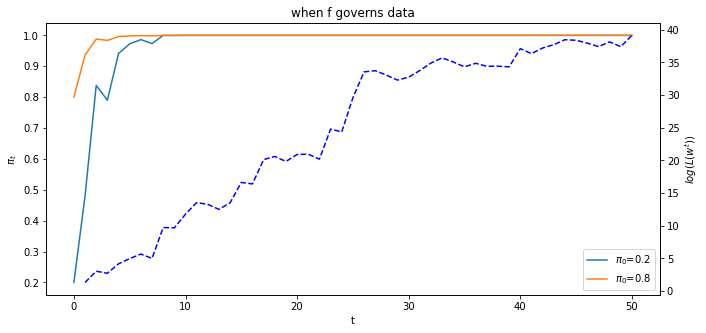

In [9]:
fig, ax1 = plt.subplots()

for i in range(2):
    ax1.plot(range(T+1), π_seq_f[i, :], label=f"$\pi_0$={π_seq_f[i, 0]}")

ax1.set_ylabel("$\pi_t$")
ax1.set_xlabel("t")
ax1.legend()
ax1.set_title("when f governs data")

ax2 = ax1.twinx()
ax2.plot(range(1, T+1), np.log(l_seq_f[0, :]), '--', color='b')
ax2.set_ylabel("$log(L(w^{t}))$")

plt.show()

The dotted line in the graph above records the logarithm of the  likelihood ratio process $\log L(w^t)$.

Please note that there are two different scales on the $y$ axis.

Now let's study what happens when the history consists of IID draws from density $g$

In [10]:
T = l_arr_g.shape[1]
π_seq_g = np.empty((2, T+1))
π_seq_g[:, 0] = π1, π2

for t in range(T):
    for i in range(2):
        π_seq_g[i, t+1] = update(π_seq_g[i, t], l_arr_g[0, t])

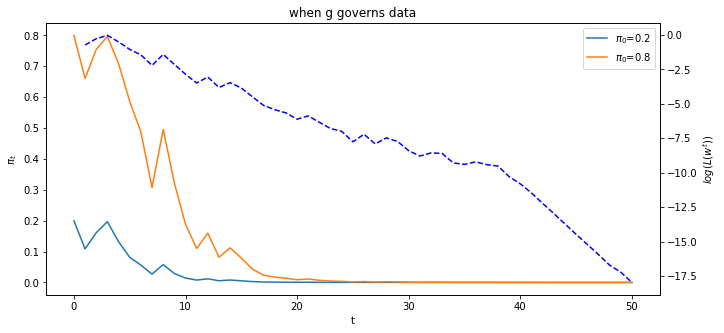

In [11]:
fig, ax1 = plt.subplots()

for i in range(2):
    ax1.plot(range(T+1), π_seq_g[i, :], label=f"$\pi_0$={π_seq_g[i, 0]}")

ax1.set_ylabel("$\pi_t$")
ax1.set_xlabel("t")
ax1.legend()
ax1.set_title("when g governs data")

ax2 = ax1.twinx()
ax2.plot(range(1, T+1), np.log(l_seq_g[0, :]), '--', color='b')
ax2.set_ylabel("$log(L(w^{t}))$")

plt.show()

Below we offer Python code that verifies that nature chose permanently to draw from density $f$.

In [12]:
π_seq = np.empty((2, T+1))
π_seq[:, 0] = π1, π2

for i in range(2):
    πL = π_seq[i, 0] * l_seq_f[0, :]
    π_seq[i, 1:] = πL / (πL + 1 - π_seq[i, 0])

In [13]:
np.abs(π_seq - π_seq_f).max() < 1e-10

True

We thus conclude that  the likelihood ratio process is a key ingredient of the formula {eq}`eq_Bayeslaw103` for
a Bayesian's posteior probabilty that nature has drawn history $w^t$ as repeated draws from density
$g$.

## Sequels

This lecture has been devoted to building some useful infrastructure.

We'll build on results highlighted in this lectures to understand inferences that are the foundations of
results described  in {doc}`this lecture <odu>` and {doc}`this lecture <wald_friedman>` and {doc}`this lecture <navy_captain>`.